In [1]:
library(ggplot2)
library(gridExtra)
library(grid)
library(scales)
library(dplyr)
library(glue)
library(stringr)
library(comprehenr)
library(purrr)
library(tibble)


Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘purrr’


The following object is masked from ‘package:scales’:

    discard




Spiega perchè binomial

In [2]:
n   <- 75
y   <- 6

freq_prob <- y/n

mu  <- 0.15
std <- 0.14
alpha <- - mu * (std^2 + mu^2 - mu) / std^2
beta  <- (std^2 + mu^2 - mu)*(mu - 1) / std^2

#posterior is a Beta distribution but with the following alpha and beta values
alpha_post <- alpha + y
beta_post  <- beta + n - y

n_sample <- 200
p     <- seq(0,1, length.out=n_sample)
beta_distr <- dbeta(p, alpha_post, beta_post) #/ (sum(dbeta(p, alpha_post, beta_post)) / n_sample )

mu_post  <- alpha_post / (alpha_post + beta_post)
std_post <- sqrt((alpha_post*beta_post)/((alpha_post+beta_post)^2*(alpha_post+beta_post+1)))

In [16]:
cat("alpha prior", alpha,"\n")
cat("beta prior", beta,"\n")
cat("alpha posterior", alpha_post,"\n")
cat("beta posterior", beta_post,"\n")
cat("beta posterior mean", mu_post,"\n")
cat("beta posterior std", std_post,"\n")


alpha prior 0.8257653 
beta prior 4.679337 
alpha posterior 6.825765 
beta posterior 73.67934 
beta posterior mean 0.08478674 
beta posterior std 0.03085551 


In [15]:
cat("the frequentist estimator of the failure probability of the new method", freq_prob,"\n")
cat("The estimator in the Bayesian case is",round(mu_post,3),"with a standard daviation",round(std_post,3),"\n")

the frequentist estimator of the failure probability of the new method 0.08 
The estimator in the Bayesian case is 0.085 with a standard daviation 0.031 


It looks clear, the frequentist approach estimator differs noticeably from the Bayesian one. Anyway, the two values remain compatible within one sigma.

Let's plot now the posterior 

Warning message:
“Removed 120 row(s) containing missing values (geom_path).”
Warning message:
“Removed 120 row(s) containing missing values (geom_path).”


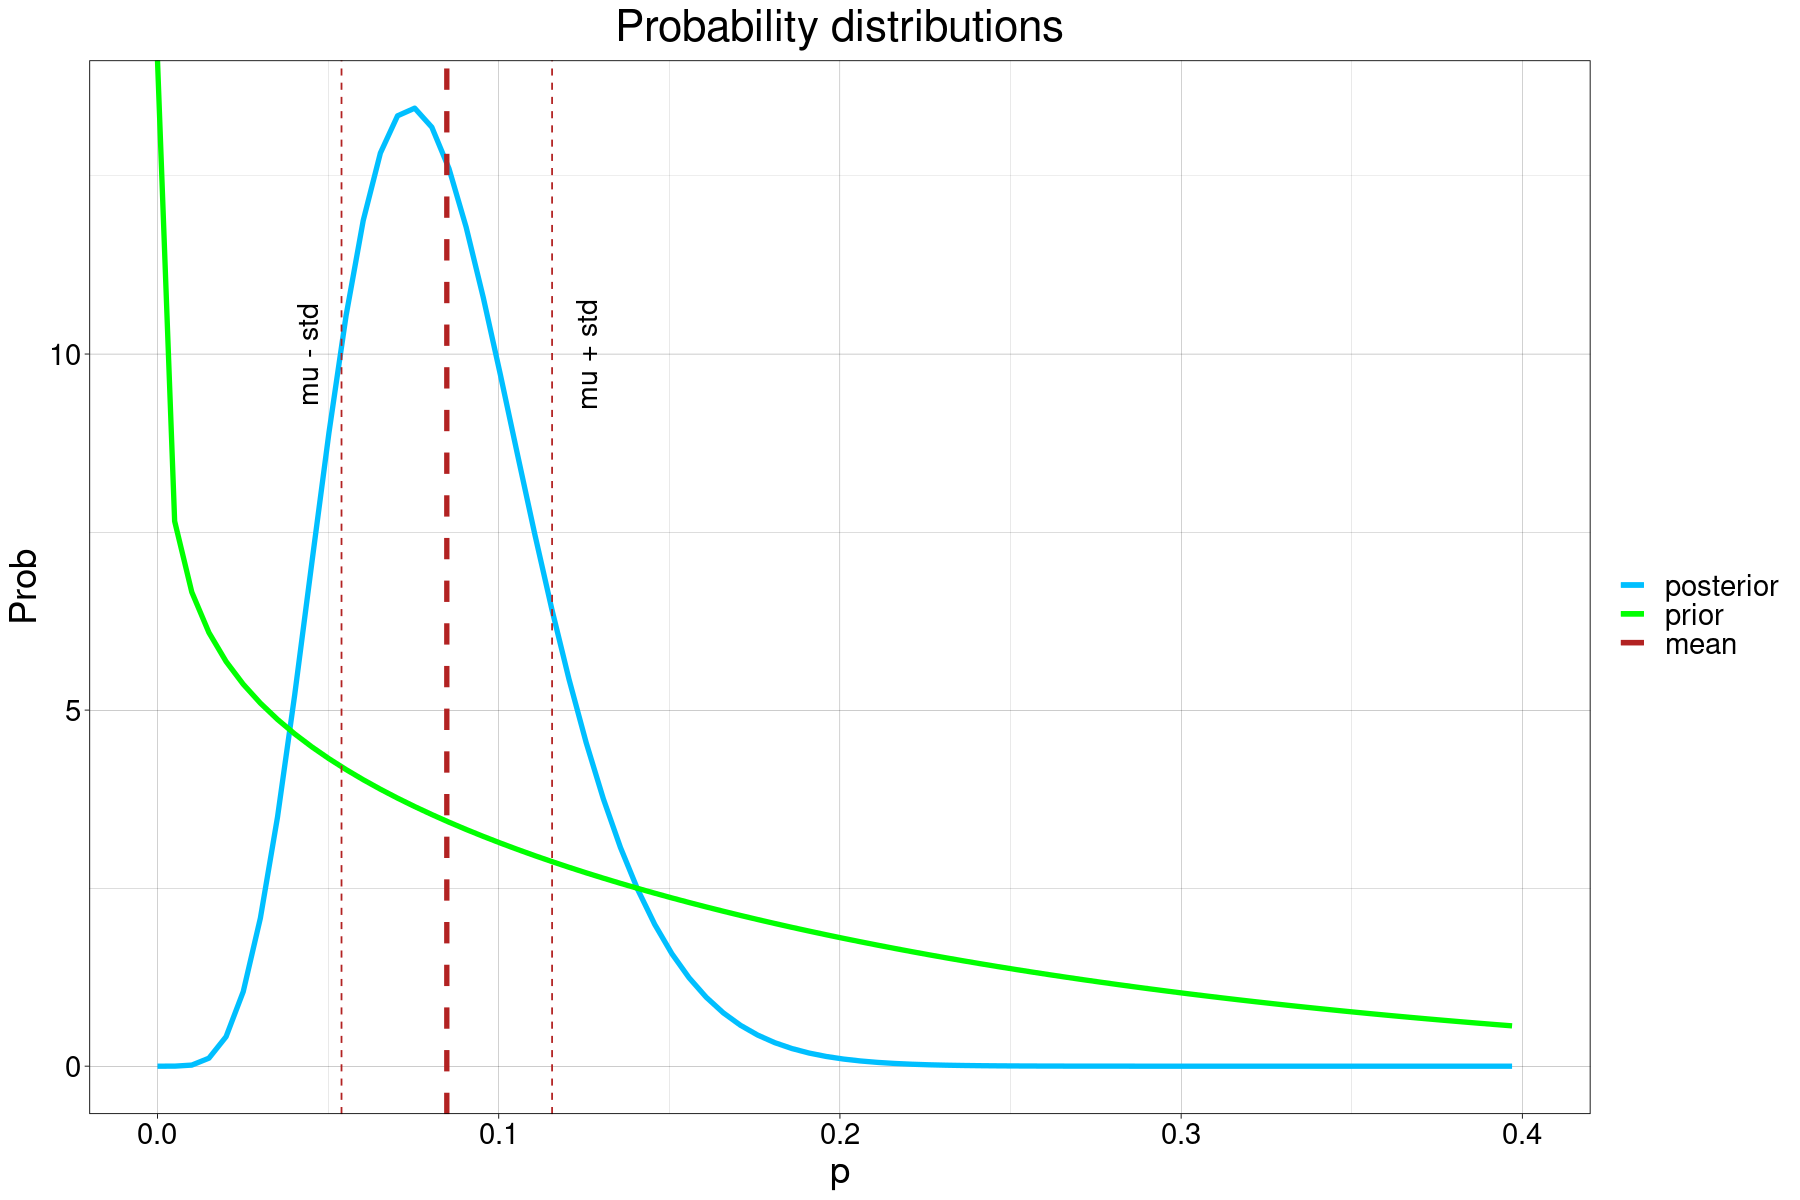

In [14]:
options(repr.plot.width=15, repr.plot.height=10)

plot <- ggplot() +
        geom_line(aes(x=p, y=beta_distr, color="posterior"),lwd=1.5) + 
        geom_line(aes(x=p, y=dbeta(p, alpha, beta), color="prior"),lwd=1.5) + 
        geom_vline(xintercept = mu_post, linetype="dashed", color="firebrick", lwd=1.5) +
        geom_vline(xintercept = (mu_post + std_post), linetype="dashed", color="firebrick") +
        geom_vline(xintercept = (mu_post - std_post), linetype="dashed", color="firebrick") +
        theme_linedraw() +
        xlim(0,0.4)+
        scale_color_manual(name = "", values = c("posterior" = "deepskyblue","prior"="green", "mean" = "firebrick" ))+
        labs(title=glue("Probability distributions"), x="p",y="Prob")+
        theme(text = element_text(size=22), plot.title = element_text( hjust = 0.5))+
        annotate("text", x=(mu_post + std_post)+0.01, y=10, label= "mu + std",angle=90, size=6) + 
        annotate("text", x=(mu_post - std_post)-0.01, y=10, label= "mu - std",angle=90, size=6)
            
plot

First of all let's define the Null hypotesis: $ \text{H}_0$ is that $H_0 : p \geq p_0$ where $p_0 = 15$% which correspond to "the new method is no better than the previous one"\
Then it follow the alternative hypothesis: $ \text{H}_1$ is that $H_1 : p < p_0$


### Bayesian:
We need to calculate the posterior of the null hypothesis as the integral of the posterior:
\begin{equation}
P(H_0| y) = \int _{p_0} ^1 g(p|y) \> dp = 1 - \text{cdf}(p_0)
\end{equation}
We set the level of significance at $\alpha = 5$%

In [26]:
p_0 <- 0.15 #15%
a <- 0.05
p_alpha  <- qbeta(1-a, alpha_post, beta_post)
p_h0 <- 1 - pbeta(p, alpha_post, beta_post)


Warning message:
“Removed 150 row(s) containing missing values (geom_path).”


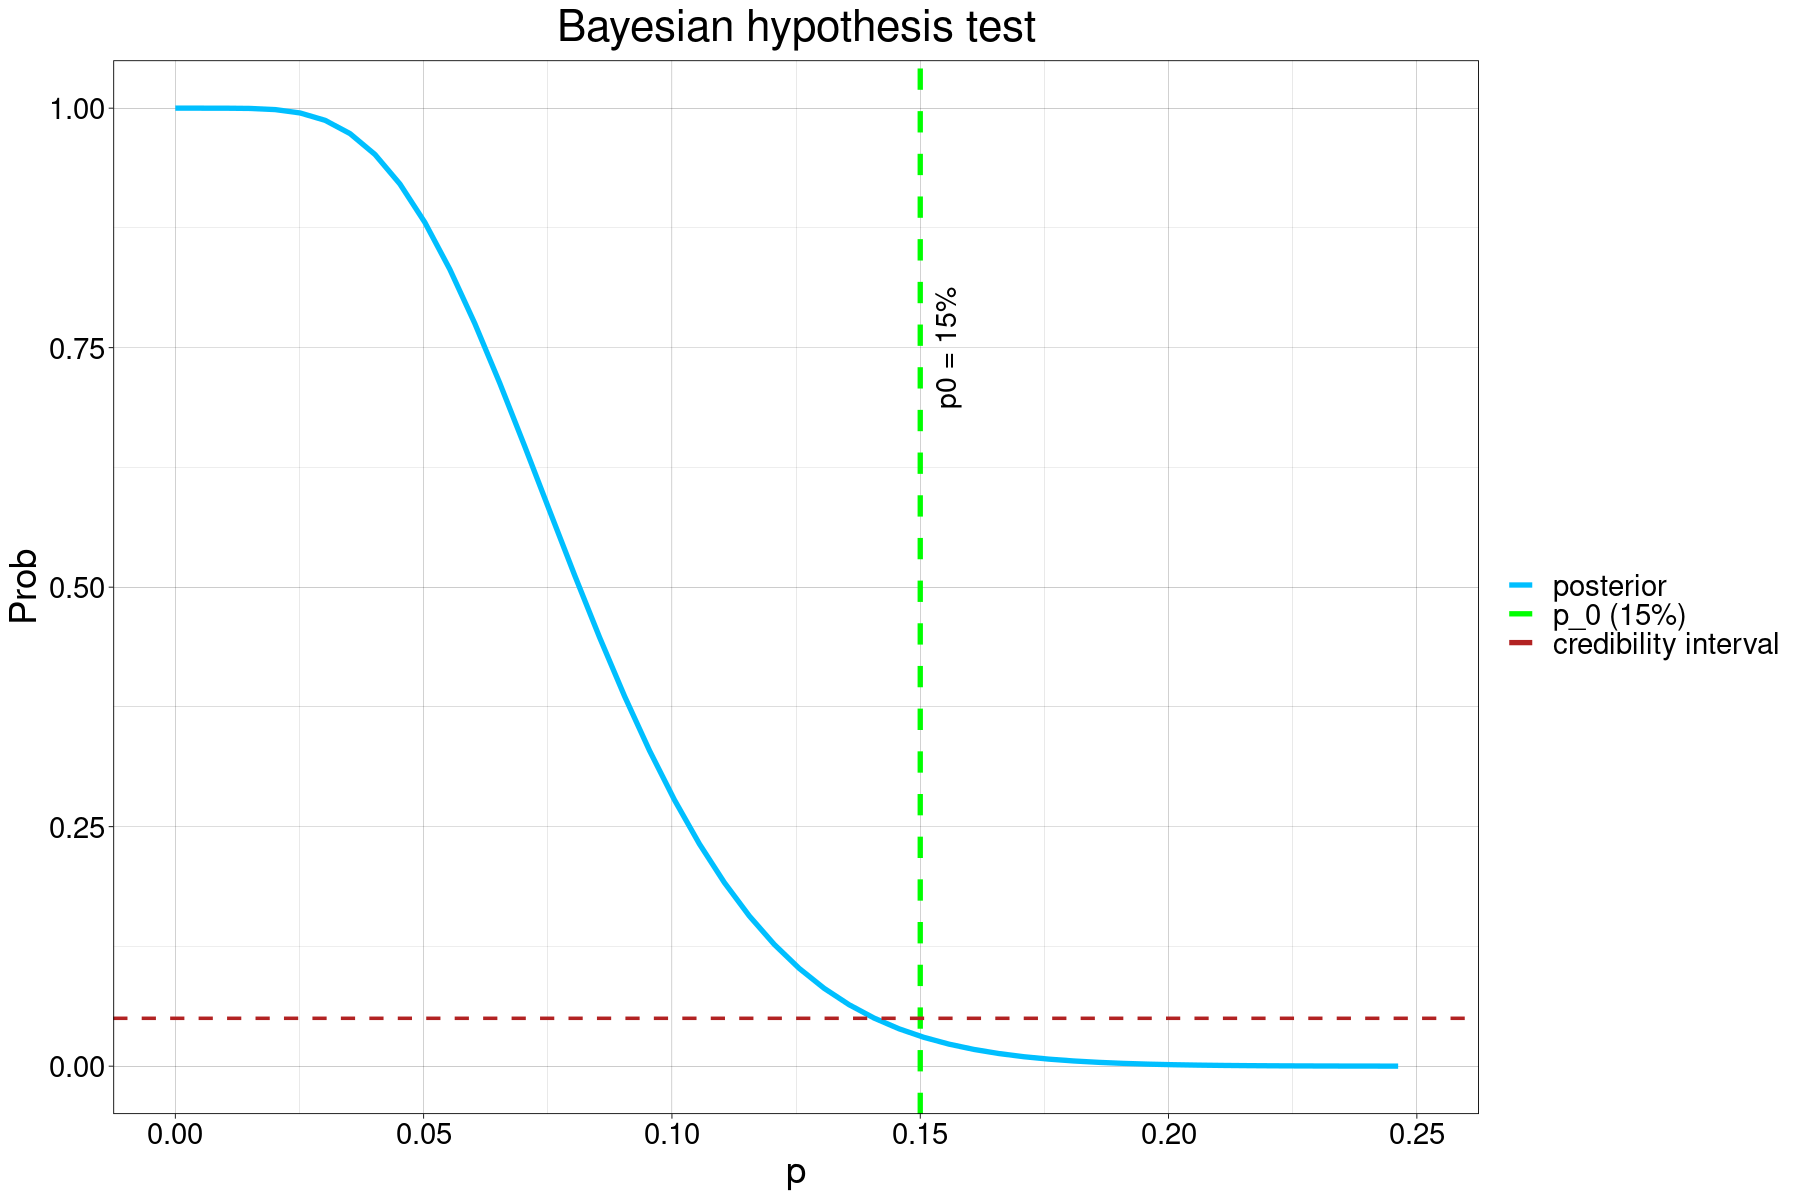

In [43]:
options(repr.plot.width=15, repr.plot.height=10)

plot <- ggplot() +
        geom_line(aes(x=p, y=p_h0, color="posterior"),lwd=1.5) + 
        geom_vline(xintercept = p_0, linetype="dashed", color="green", lwd=1.5) +
        geom_hline(yintercept = a, linetype="dashed", color="firebrick",lwd=1) +
        theme_linedraw() +
        xlim(0,0.25)+
        scale_color_manual(name = "", values = c("posterior" = "deepskyblue","p_0 (15%)"="green", "credibility interval" = "firebrick" ))+
        labs(title=glue("Bayesian hypothesis test"), x="p",y="Prob")+
        theme(text = element_text(size=22), plot.title = element_text( hjust = 0.5))+
        annotate("text", x=p_0+0.005, y=0.75, label= "p0 = 15%",angle=90, size=6) 
plot


As we can see the 15% of probabiliti falls in the credibility interval

Warning message:
“Removed 140 row(s) containing missing values (geom_path).”


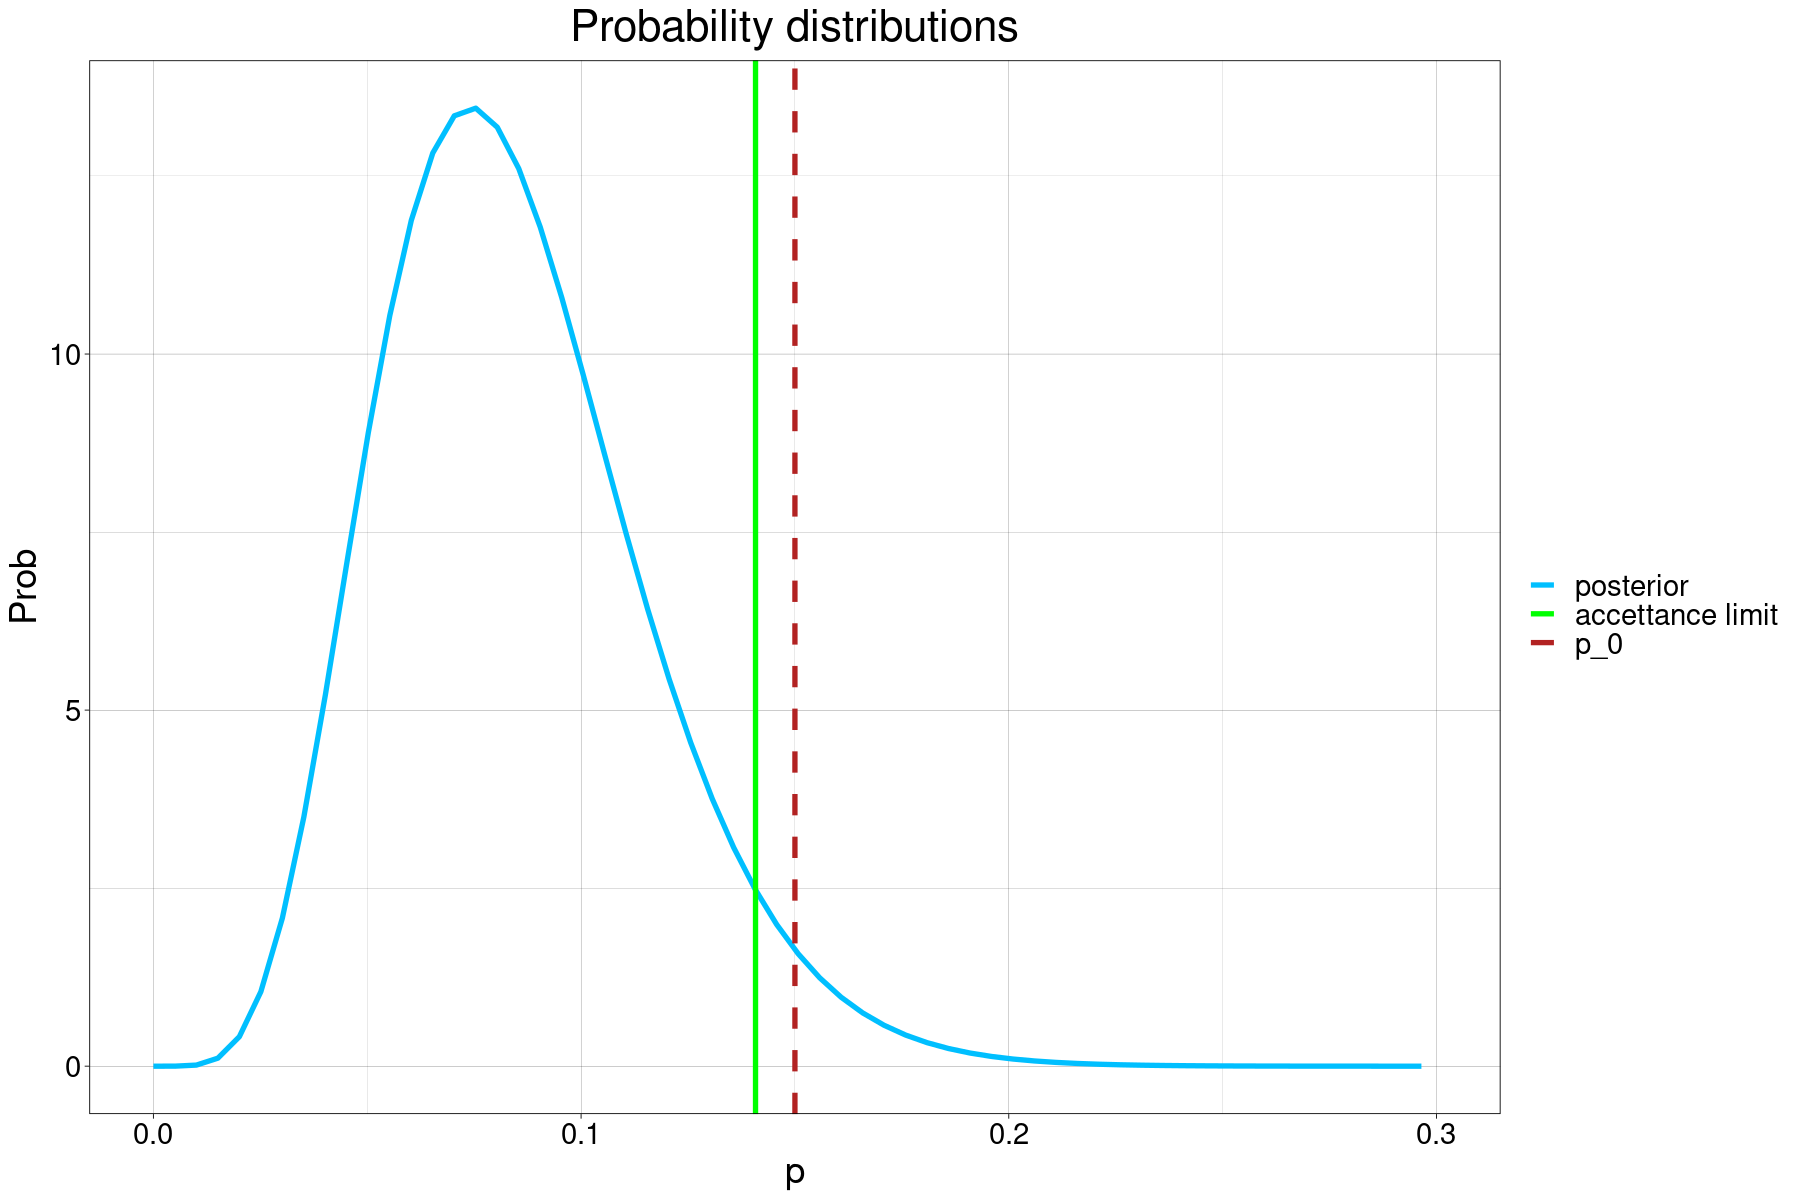

In [52]:
p_acc <- seq(0,  p_alpha,  length.out=150)
p_rej <- seq(p_alpha, 0.3, length.out=150)

plot <- ggplot() +
        geom_line(aes(x=p, y=beta_distr, color="posterior"),lwd=1.5) + 
        geom_vline(xintercept = p_alpha, color="green", lwd=1.5) +
        geom_vline(xintercept = p_0, linetype="dashed", color="firebrick", lwd=1.5) +
        theme_linedraw() +
        xlim(0,0.3)+
        scale_color_manual(name = "", values = c("posterior" = "deepskyblue","accettance limit"="green", "p_0" = "firebrick" ))+
        labs(title=glue("Probability distributions"), x="p",y="Prob")+
        theme(text = element_text(size=22), plot.title = element_text( hjust = 0.5))
            
plot

### Frequentist

Null distribution 

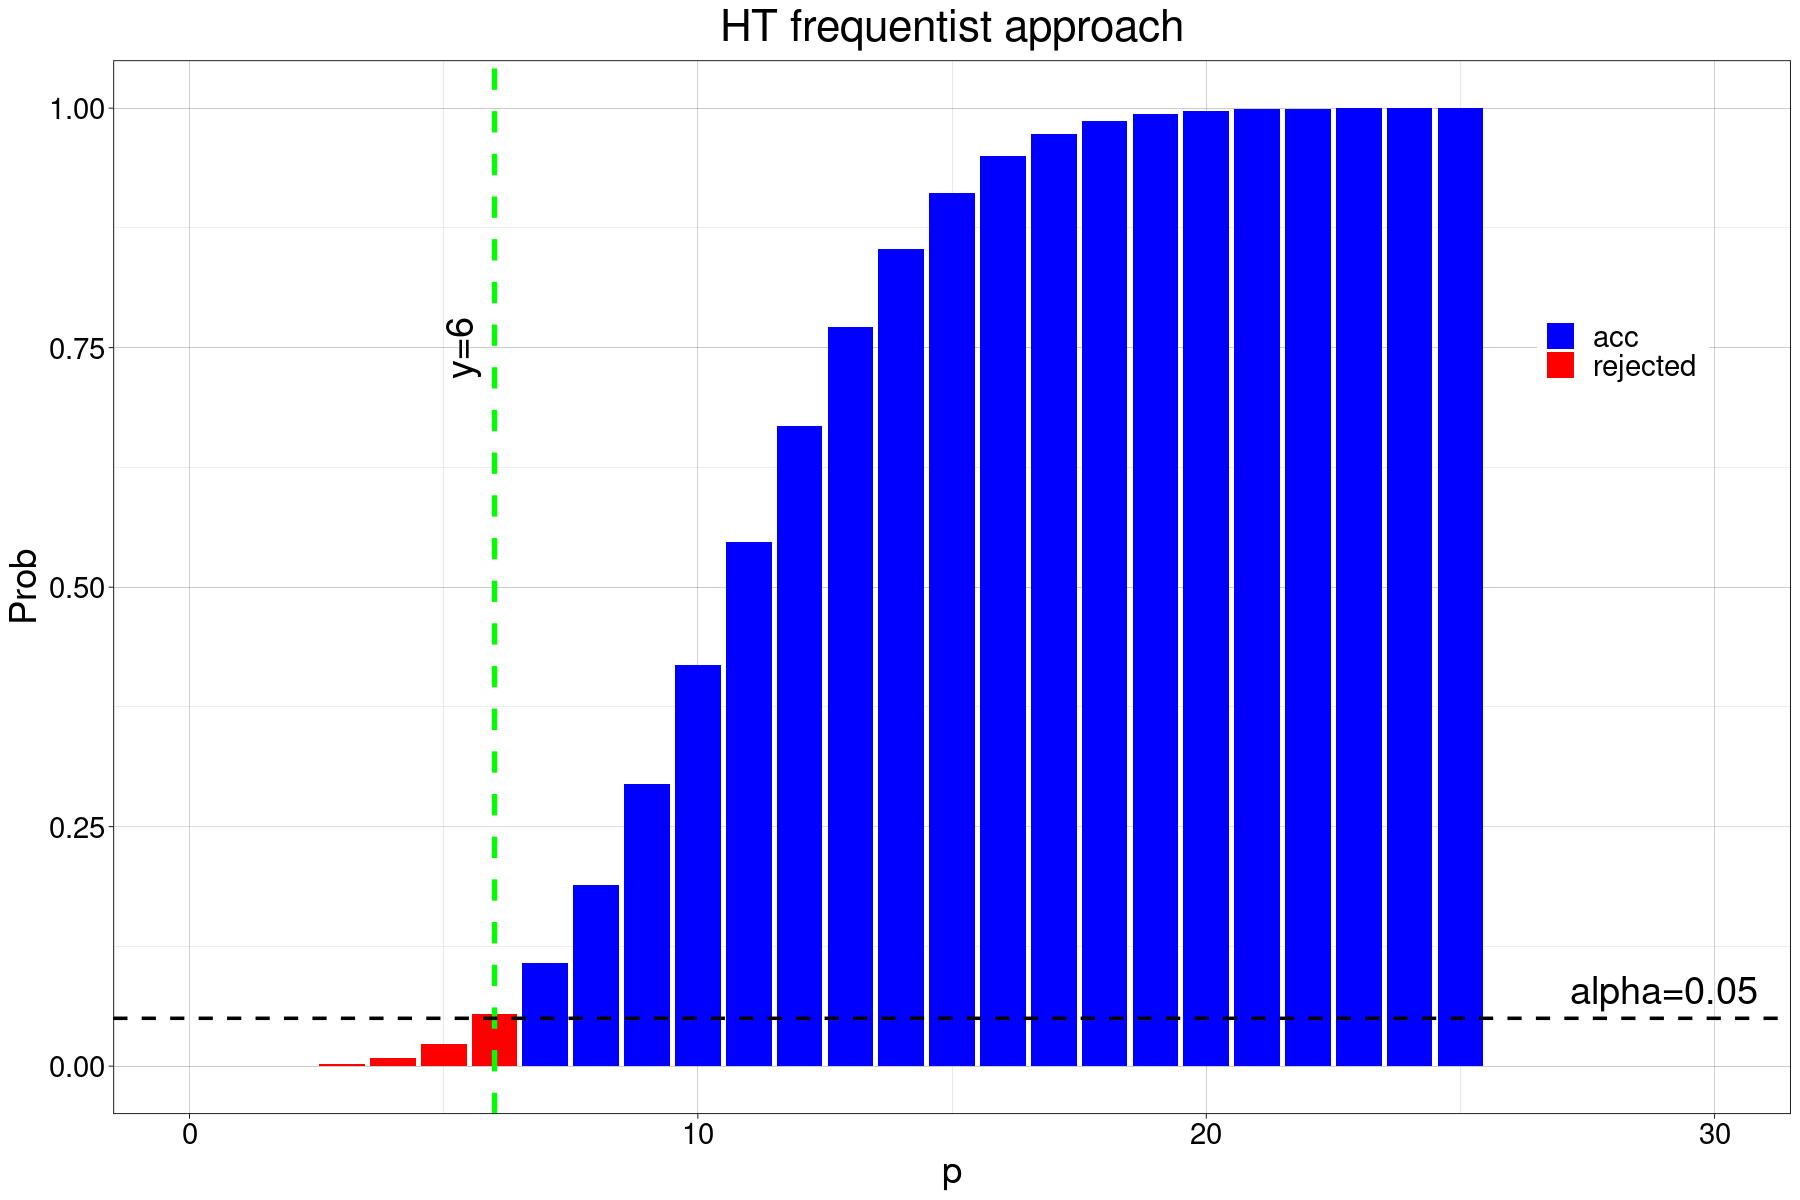

In [72]:
y_i <- 1:25
p_test <- pbinom(y_i, n, p_0)

y_acc  <- y_i[p_test > 1-a]
y_rej  <- y_i[p_test < 1-a]

pp_test <- dbinom(y_i, n, p_0)

col <- c(rep("rejected",6),rep("acc",length(p_test)-6))

df <- data.frame(y_i, p_test, col)

options(repr.plot.width=15, repr.plot.height=10)
barp <- ggplot(df, aes(x=y_i, y=p_test, fill=col)) +
        geom_bar(stat="identity")+
        geom_vline(xintercept = y, linetype="dashed", color="green", lwd=1.5) +
        geom_hline(yintercept = a, linetype="dashed", color="black", lwd=1) +
        theme_linedraw() +
        xlim(0,30)+
        scale_fill_manual(name="",values = c("blue","red") )+
        labs(title=glue("HT frequentist approach"), x="p",y="Prob")+
        theme(text = element_text(size=22), plot.title = element_text( hjust = 0.5), 
                legend.position=c(.9,.75))+
        annotate("text", x=5.3, y=0.75, label= "y=6",angle=90, size=8) +
        annotate("text", x=29,  y=0.08,  label= "alpha=0.05", size=8) 
barp

## conclusione

## Es2

uniform prior is like a gamma distribution Gamma(1,0)/
Jeffres' prior is Gamma(1/2,0)

Posterior is a gamma again but with particular alpha e lambda


In [397]:
n1 <- c(109,65,22,3,1,0)
n2 <- c(144,91,32,11,2,0)
y_death <- 0:4
deaths1 <- NULL; deaths2 <- NULL # equivalent to using c()

for (i in 1:5) {
    deaths1 <- append(deaths1, values = rep(y_death[i], times = n1[i]))
    deaths2 <- append(deaths2, values = rep(y_death[i], times = n2[i]))
}

alpha_u1 <- sum(deaths1) + 1
alpha_u2 <- sum(deaths2) + 1
lambda1  <- length(deaths1)
lambda2  <- length(deaths2)

n_sample <- 1000
# p <- seq(20,60, length.out=n_sample)
p <- seq(0,2, length.out=n_sample)
post_u1 <- dgamma(p, alpha_u1,lambda1) / (sum(dgamma(p, alpha_u1,lambda1) )/n_sample)
post_u2 <- dgamma(p, alpha_u2,lambda2) / (sum(dgamma(p, alpha_u2,lambda2) )/n_sample)


For the mean and std values we follow the formula for the Gamma distribution. To calulate the median we use the definition

In [398]:
mean_u1 <- alpha_u1/lambda1; var_u1 <- alpha_u1/lambda1^2 
mean_u2 <- alpha_u2/lambda2; var_u2 <- alpha_u2/lambda2^2 

median_u1 <- p[length(which( cumsum(post_u1) / n_sample <= 0.5))]
median_u2 <- p[length(which( cumsum(post_u2) / n_sample <= 0.5))]

u1_low  <- qgamma(0.025, alpha_u1, lambda1); u1_high <- qgamma(0.975, alpha_u1, lambda1)
u2_low  <- qgamma(0.025, alpha_u2, lambda2); u2_high <- qgamma(0.975, alpha_u2, lambda2)


In [399]:
cat("Uniform prior, first dataset \n")
cat("\t mean=", mean_u1,"\n")
cat("\t var=", var_u1,"\n")
cat("\t meadian=", median_u1,"\n")
cat("\t 95% credibility interval boundary [", u1_low,"-", u1_high,"]\n")

cat("Uniform prior, second dataset \n")
cat("\t mean=", mean_u2,"\n")
cat("\t var=", var_u2,"\n")
cat("\t meadian=", median_u2,"\n")
cat("\t 95% credibility interval boundary [", u2_low,"-", u2_high,"]\n")


Uniform prior, first dataset 
	 mean= 0.615 
	 var= 0.003075 
	 meadian= 0.6106106 
	 95% credibility interval boundary [ 0.5111251 - 0.7283408 ]
Uniform prior, second dataset 
	 mean= 0.7035714 
	 var= 0.002512755 
	 meadian= 0.7007007 
	 95% credibility interval boundary [ 0.6087487 - 0.805157 ]


Warning message:
“Removed 625 row(s) containing missing values (geom_path).”
Warning message:
“Removed 625 row(s) containing missing values (geom_path).”
Warning message:
“Removed 625 row(s) containing missing values (geom_path).”


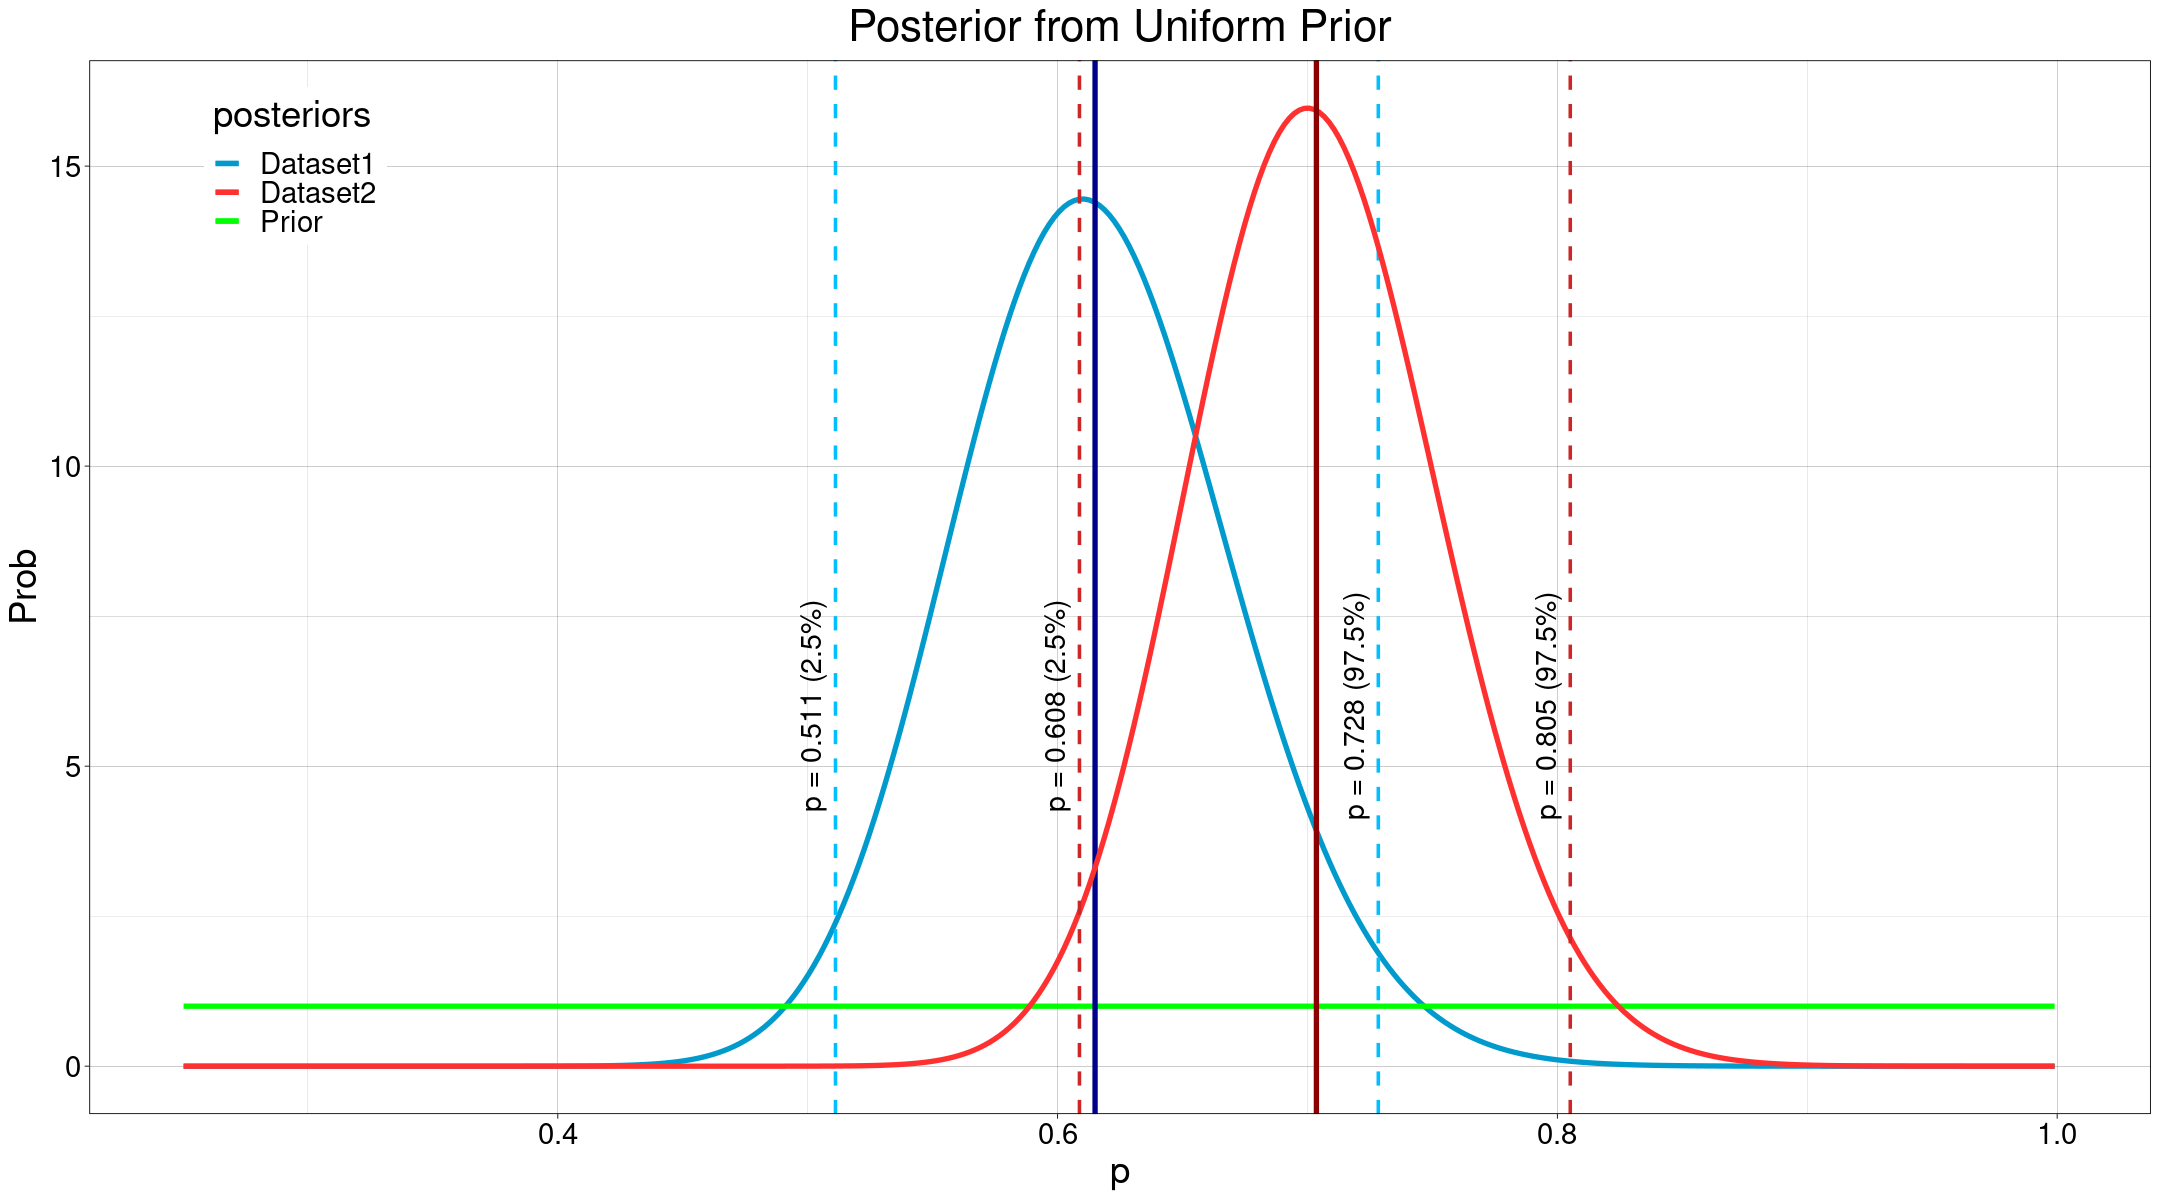

In [421]:
options(repr.plot.width=18, repr.plot.height=10)

plot <- ggplot() +
        geom_line(aes(x=p, y=post_u1, color="Dataset1"),lwd=1.5) + 
        geom_line(aes(x=p, y=rep(1, length(p))), color="green",lwd=1.5) + 
        geom_vline(xintercept = mean_u1, color="darkblue", lwd=1.5) +
        geom_vline(xintercept = u1_low,  linetype="dashed", color="deepskyblue1",lwd=1) +
        geom_vline(xintercept = u1_high, linetype="dashed", color="deepskyblue1", lwd=1) +

        geom_line(aes(x=p, y=post_u2, color="Dataset2"),lwd=1.5) + 
        geom_vline(xintercept = mean_u2, color="darkred", lwd=1.5) +
        geom_vline(xintercept = u2_low,  linetype="dashed", color="firebrick3",lwd=1) +
        geom_vline(xintercept = u2_high, linetype="dashed", color="firebrick3", lwd=1) +
        xlim(0.25,1)+
        

        annotate("text", x=u1_low-0.01, y=6, label= "p = 0.511 (2.5%)",angle=90, size=6) + 
        annotate("text", x=u1_high-0.01, y=6,label= "p = 0.728 (97.5%)",angle=90, size=6) + 
        annotate("text", x=u2_low-0.01, y=6, label= "p = 0.608 (2.5%)",angle=90, size=6) + 
        annotate("text", x=u2_high-0.01, y=6, label= "p = 0.805 (97.5%)",angle=90, size=6) + 
        
        scale_color_manual(name = "posteriors", values = c("Dataset1" = "deepskyblue3", "Dataset2"="firebrick1","Prior"="green"))+
        theme_linedraw() +
        labs(title=glue("Posterior from Uniform Prior"), x="p",y="Prob")+
        theme(text = element_text(size=22), plot.title = element_text( hjust = 0.5), legend.position=c(.1,.90))

plot


In these plots we can see the posteriors from the two different datasets, with its mean and the 95% credibilty interval. 

### Jeffries' Prior

In [416]:
alpha_j1 <- sum(deaths1) + 0.5
alpha_j2 <- sum(deaths2) + 0.5

post_j1 <- dgamma(p, alpha_j1,lambda1) / (sum(dgamma(p, alpha_j1,lambda1) )/n_sample)
post_j2 <- dgamma(p, alpha_j2,lambda2) / (sum(dgamma(p, alpha_j2,lambda2) )/n_sample)

In [417]:
mean_j1 <- alpha_j1/lambda1; var_j1 <- alpha_j1/lambda1^2 
mean_j2 <- alpha_j2/lambda2; var_j2 <- alpha_j2/lambda2^2 

median_j1 <- p[length(which( cumsum(post_j1) / n_sample <= 0.5))]
median_j2 <- p[length(which( cumsum(post_j2) / n_sample <= 0.5))]

j1_low  <- qgamma(0.025, alpha_j1, lambda1); j1_high <- qgamma(0.975, alpha_j1, lambda1)
j2_low  <- qgamma(0.025, alpha_j2, lambda2); j2_high <- qgamma(0.975, alpha_j2, lambda2)


In [418]:
cat("Jeffires' prior, first dataset \n")
cat("\t mean=", mean_j1,"\n")
cat("\t var=", var_j1,"\n")
cat("\t meadian=", median_j1,"\n")
cat("\t 95% credibility interval boundary", j1_low,"-", j1_high,"\n")

cat("Jeffries' prior, second dataset \n")
cat("\t mean=", mean_j2,"\n")
cat("\t var=", var_j2,"\n")
cat("\t meadian=", median_j2,"\n")
cat("\t 95% credibility interval boundary", j2_low,"-", j2_high,"\n")


Jeffires' prior, first dataset 
	 mean= 0.6125 
	 var= 0.0030625 
	 meadian= 0.6086086 
	 95% credibility interval boundary 0.5088464 - 0.7256196 
Jeffries' prior, second dataset 
	 mean= 0.7017857 
	 var= 0.002506378 
	 meadian= 0.6986987 
	 95% credibility interval boundary 0.6070878 - 0.8032465 


Warning message:
“Removed 500 row(s) containing missing values (geom_path).”
Warning message:
“Removed 500 row(s) containing missing values (geom_path).”
Warning message:
“Removed 500 row(s) containing missing values (geom_path).”


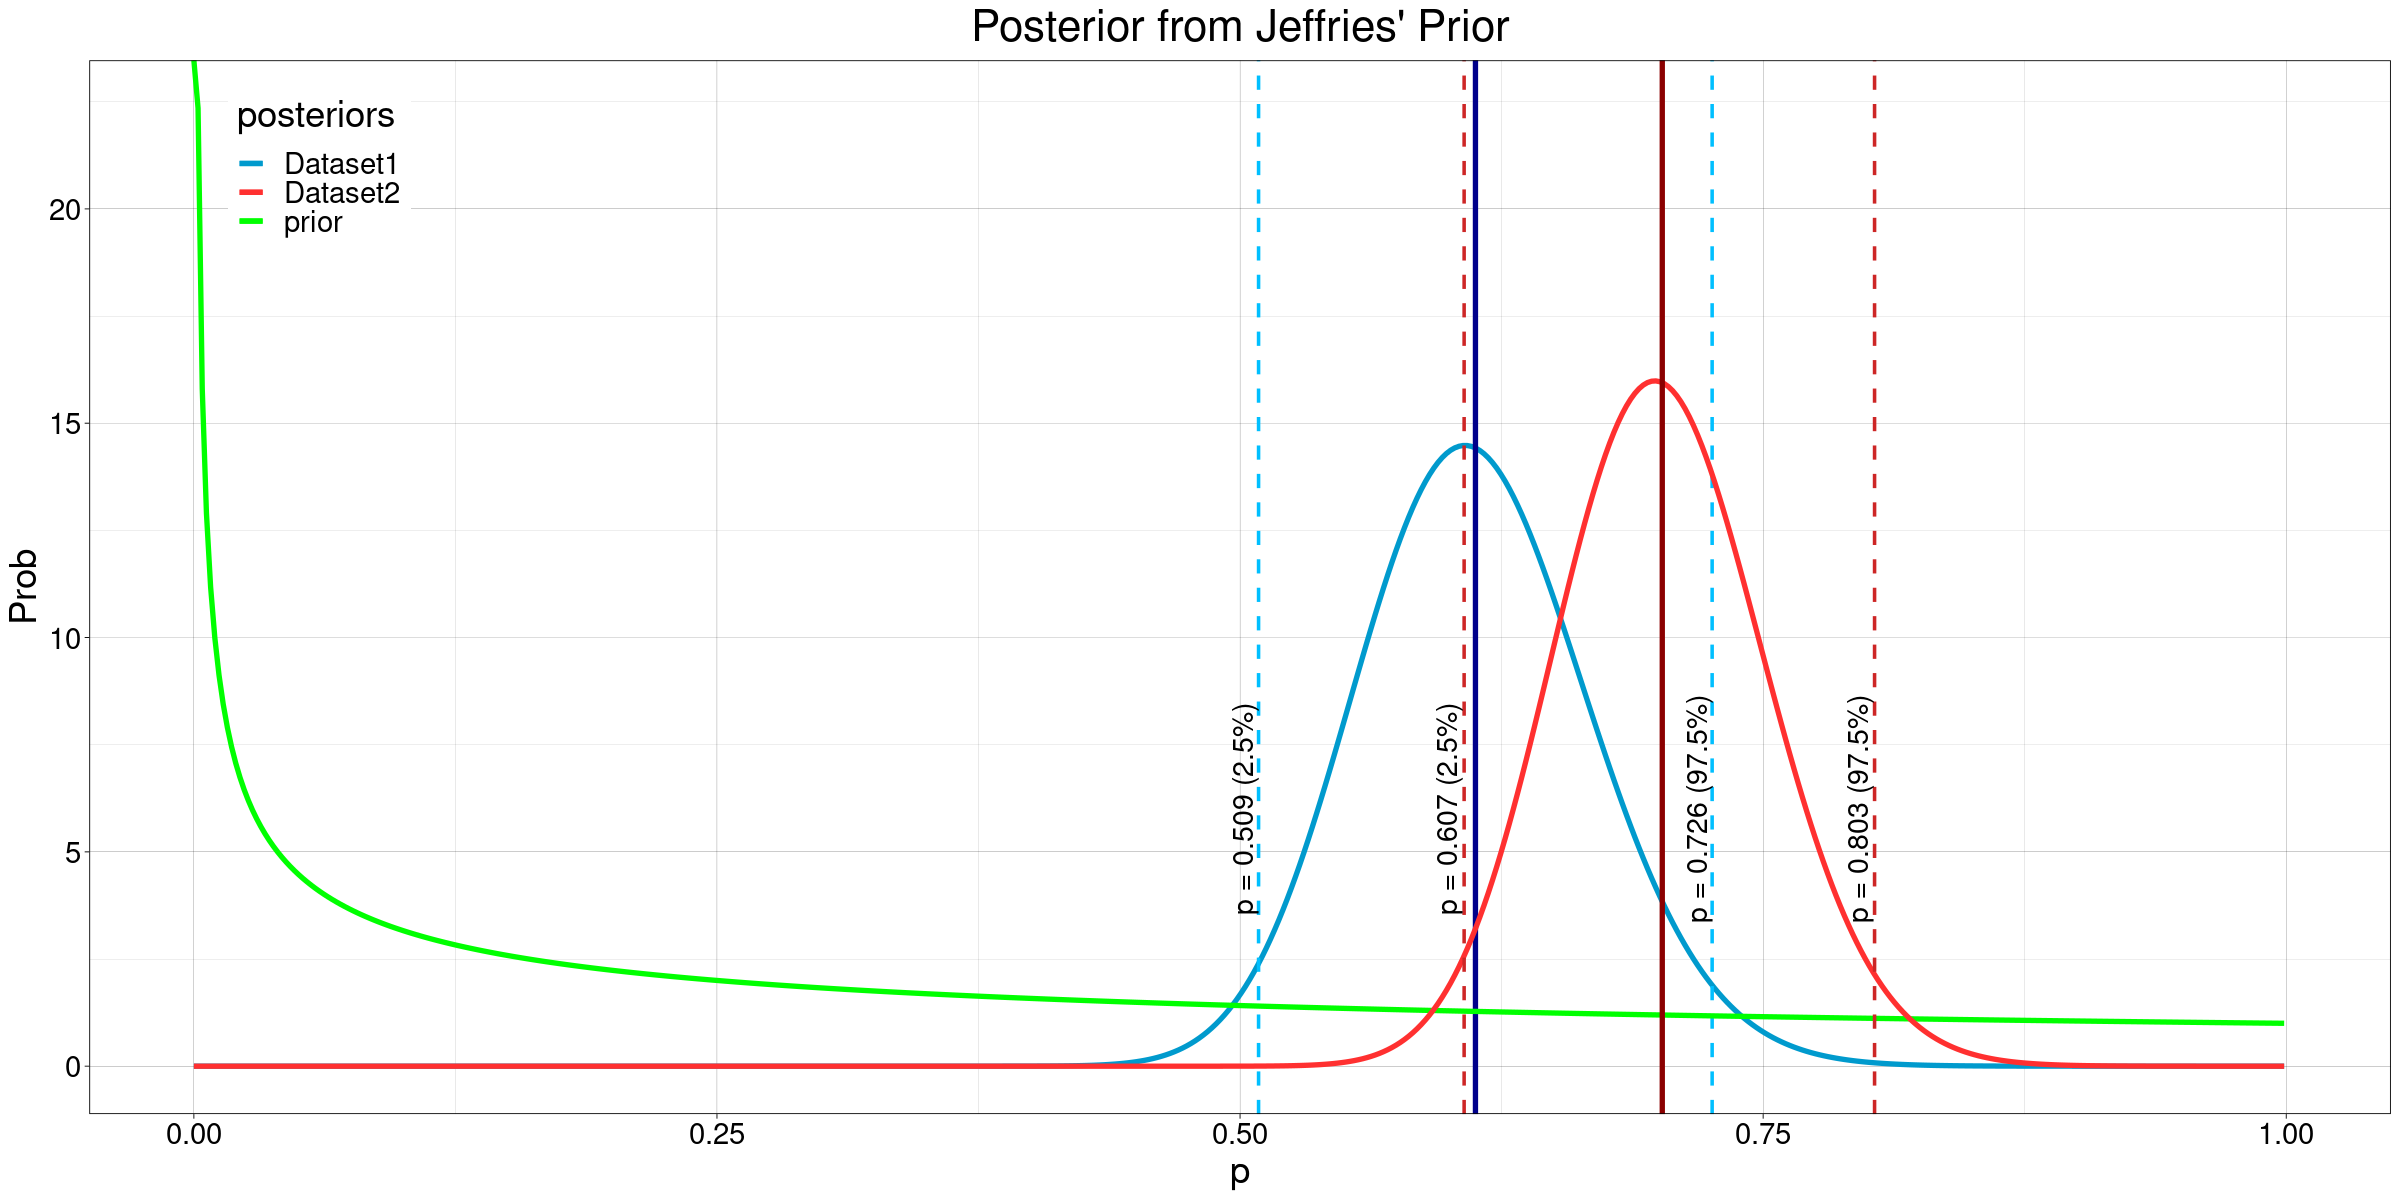

In [431]:
options(repr.plot.width=20, repr.plot.height=10)

plot <- ggplot() +
        geom_line(aes(x=p, y=post_j1, color="Dataset1"),lwd=1.5) + 
        geom_vline(xintercept = mean_j1, color="darkblue", lwd=1.5) +
        geom_vline(xintercept = j1_low,  linetype="dashed", color="deepskyblue1",lwd=1) +
        geom_vline(xintercept = j1_high, linetype="dashed", color="deepskyblue1", lwd=1) +
        geom_line(aes(x=p, y=1/sqrt(p)), color="green",lwd=1.5) + 

        geom_line(aes(x=p, y=post_j2, color="Dataset2"),lwd=1.5) + 
        geom_vline(xintercept = mean_j2, color="darkred", lwd=1.5) +
        geom_vline(xintercept = j2_low,  linetype="dashed", color="firebrick3",lwd=1) +
        geom_vline(xintercept = j2_high, linetype="dashed", color="firebrick3", lwd=1) +
        xlim(0,1)+

        annotate("text", x=u1_low-0.01, y=6, label= "p = 0.509 (2.5%)",angle=90, size=6) + 
        annotate("text", x=u1_high-0.01, y=6,label= "p = 0.726 (97.5%)",angle=90, size=6) + 
        annotate("text", x=u2_low-0.01, y=6, label= "p = 0.607 (2.5%)",angle=90, size=6) + 
        annotate("text", x=u2_high-0.01, y=6, label= "p = 0.803 (97.5%)",angle=90, size=6) + 
        
        scale_color_manual(name = "posteriors", values = c("Dataset1" = "deepskyblue3", "Dataset2"="firebrick1","prior"="green"))+
        theme_linedraw() +
        labs(title=glue("Posterior from Jeffries' Prior"), x="p",y="Prob")+
        theme(text = element_text(size=22), plot.title = element_text( hjust = 0.5), legend.position=c(.1,.90))

plot


## Es3

In [78]:
n <- 116
y <- 11

p_freq <- y/n

alpha_prior <- 1
beta_prior  <- 10

alpha <- alpha_prior + y
beta  <- beta_prior  + n - y

mu_post  <- alpha / (alpha + beta)
std_post <- sqrt((alpha*beta)/((alpha+beta)^2*(alpha+beta+1)))

n_sample <- 1000
p <- seq(0,1, length.out=n_sample)
prior <- dbeta(p, alpha_prior, beta_prior)
post  <- dbeta(p, alpha, beta)


We assume a $Beta (1,10)$ prior. For the likelihood we asssume a Binomial distribution since the data recall the binomial pdf properties. \
These choice implies a posterior which is a $Beta(\alpha, \beta)$ too but with particular value for the two parameters.


Warning message:
“Removed 700 row(s) containing missing values (geom_path).”
Warning message:
“Removed 700 row(s) containing missing values (geom_path).”


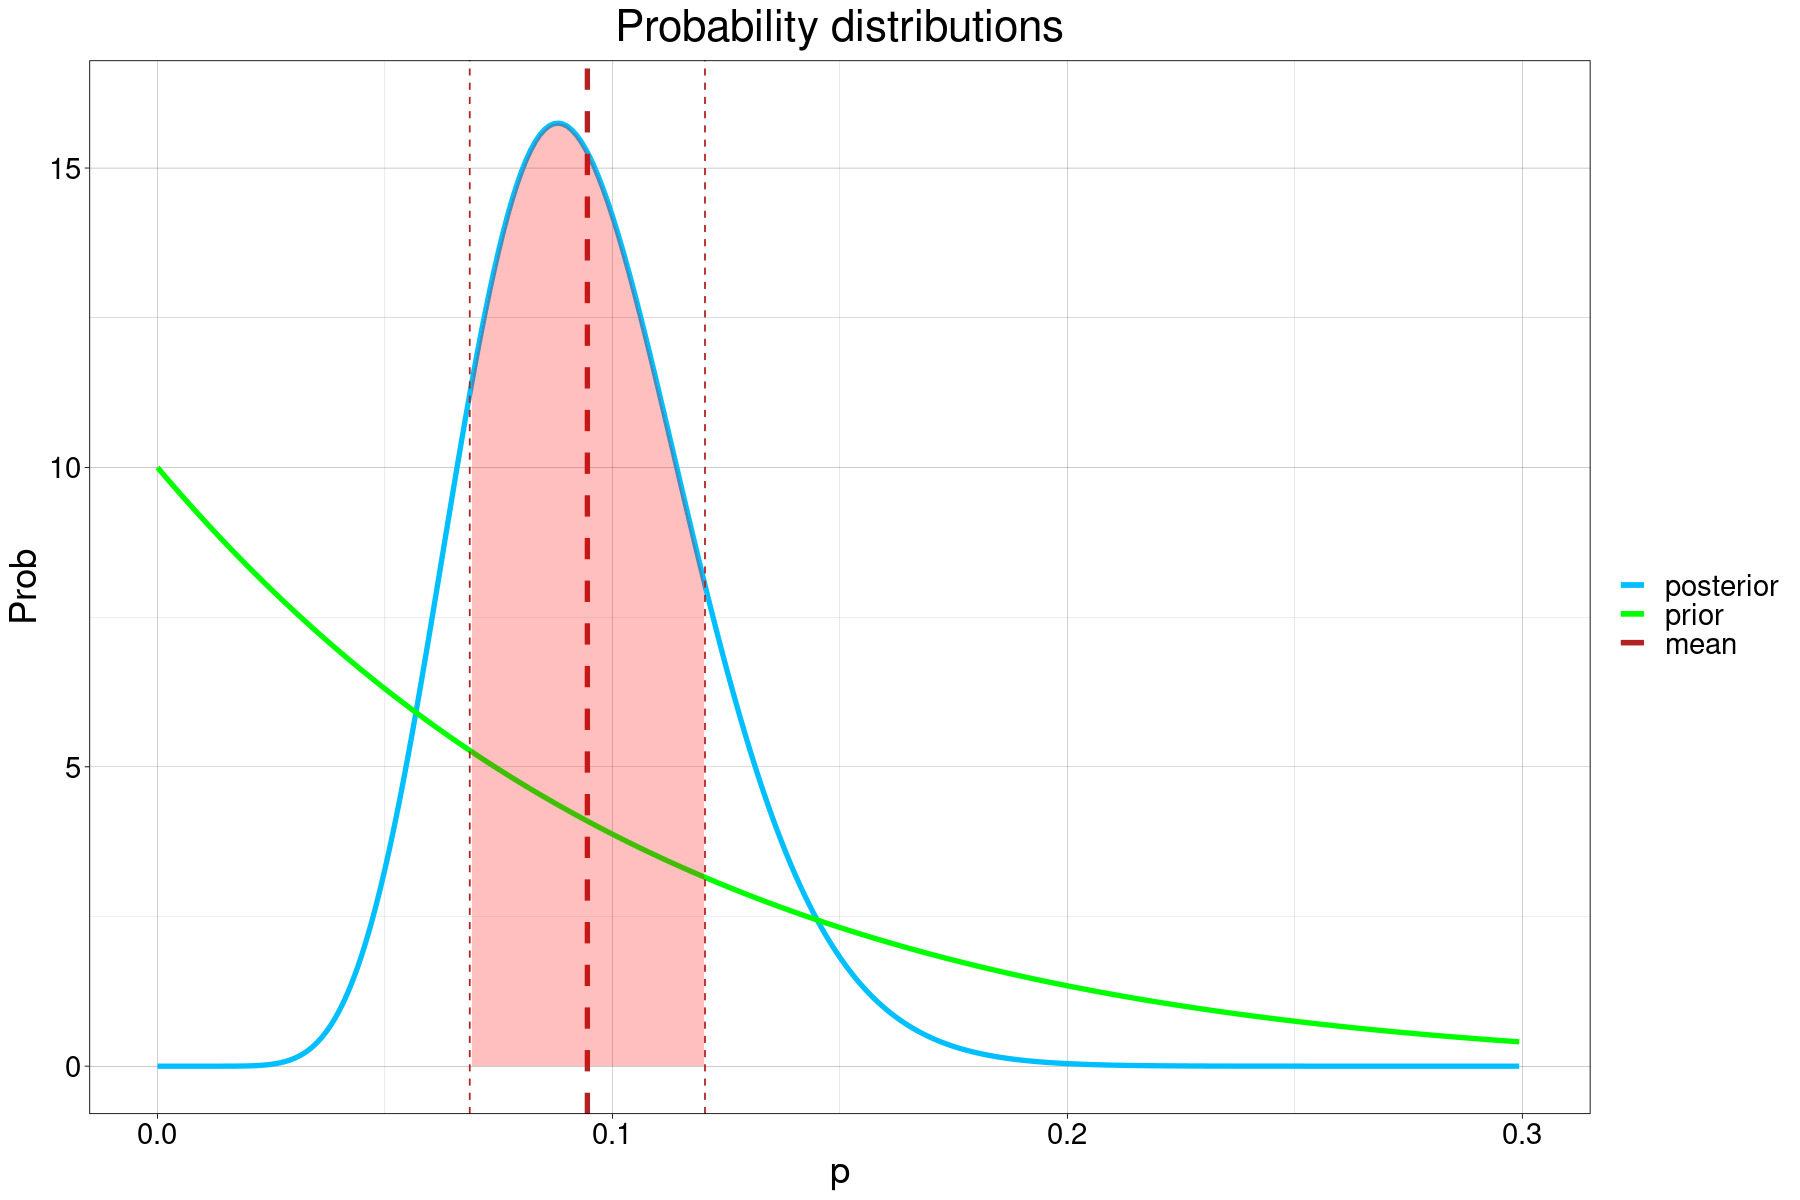

In [151]:
options(repr.plot.width=15, repr.plot.height=10)

plot <- ggplot() +
        geom_line(aes(x=p, y=post, color="posterior"),lwd=1.5) + 
        geom_line(aes(x=p, y=prior, color="prior"),lwd=1.5) + 
        geom_vline(xintercept = mu_post, linetype="dashed", color="firebrick", lwd=1.5) +
        geom_vline(xintercept = (mu_post + std_post), linetype="dashed", color="firebrick") +
        geom_vline(xintercept = (mu_post - std_post), linetype="dashed", color="firebrick") +
        geom_area(aes(x = ifelse(p>(mu_post - std_post) & p<(mu_post + std_post), p, 0), y=post,), fill=adjustcolor("red",alpha.f=0.25))+
        theme_linedraw() +
        xlim(0,0.3)+
        ylim(0,16)+
        scale_color_manual(name = "", values = c("posterior" = "deepskyblue","prior"="green", "mean" = "firebrick" ))+
        labs(title=glue("Probability distributions"), x="p",y="Prob")+
        theme(text = element_text(size=22), plot.title = element_text( hjust = 0.5))
plot

In [83]:
low  <- qbeta(0.025, alpha, beta)
high <- qbeta(0.975, alpha, beta)

#results
cat("The frequentist estimator for p =",round(p_freq,3),"\n")
cat("the estimator in the Bayesian case is",round(mu_post,3),"with a std of",round(std_post,3),"\n")
cat("The credibility interval for the posterior is", round(low,4),"-",round(high,4),"\n")

The frequentist estimator for p = 0.095 
the estimator in the Bayesian case is 0.094 with a std of 0.026 
The credibility interval for the posterior is 0.0502 - 0.1508 


Test the hypotesis\
## Bayesian

Warning message:
“Removed 700 rows containing missing values (position_stack).”
Warning message:
“Removed 700 row(s) containing missing values (geom_path).”


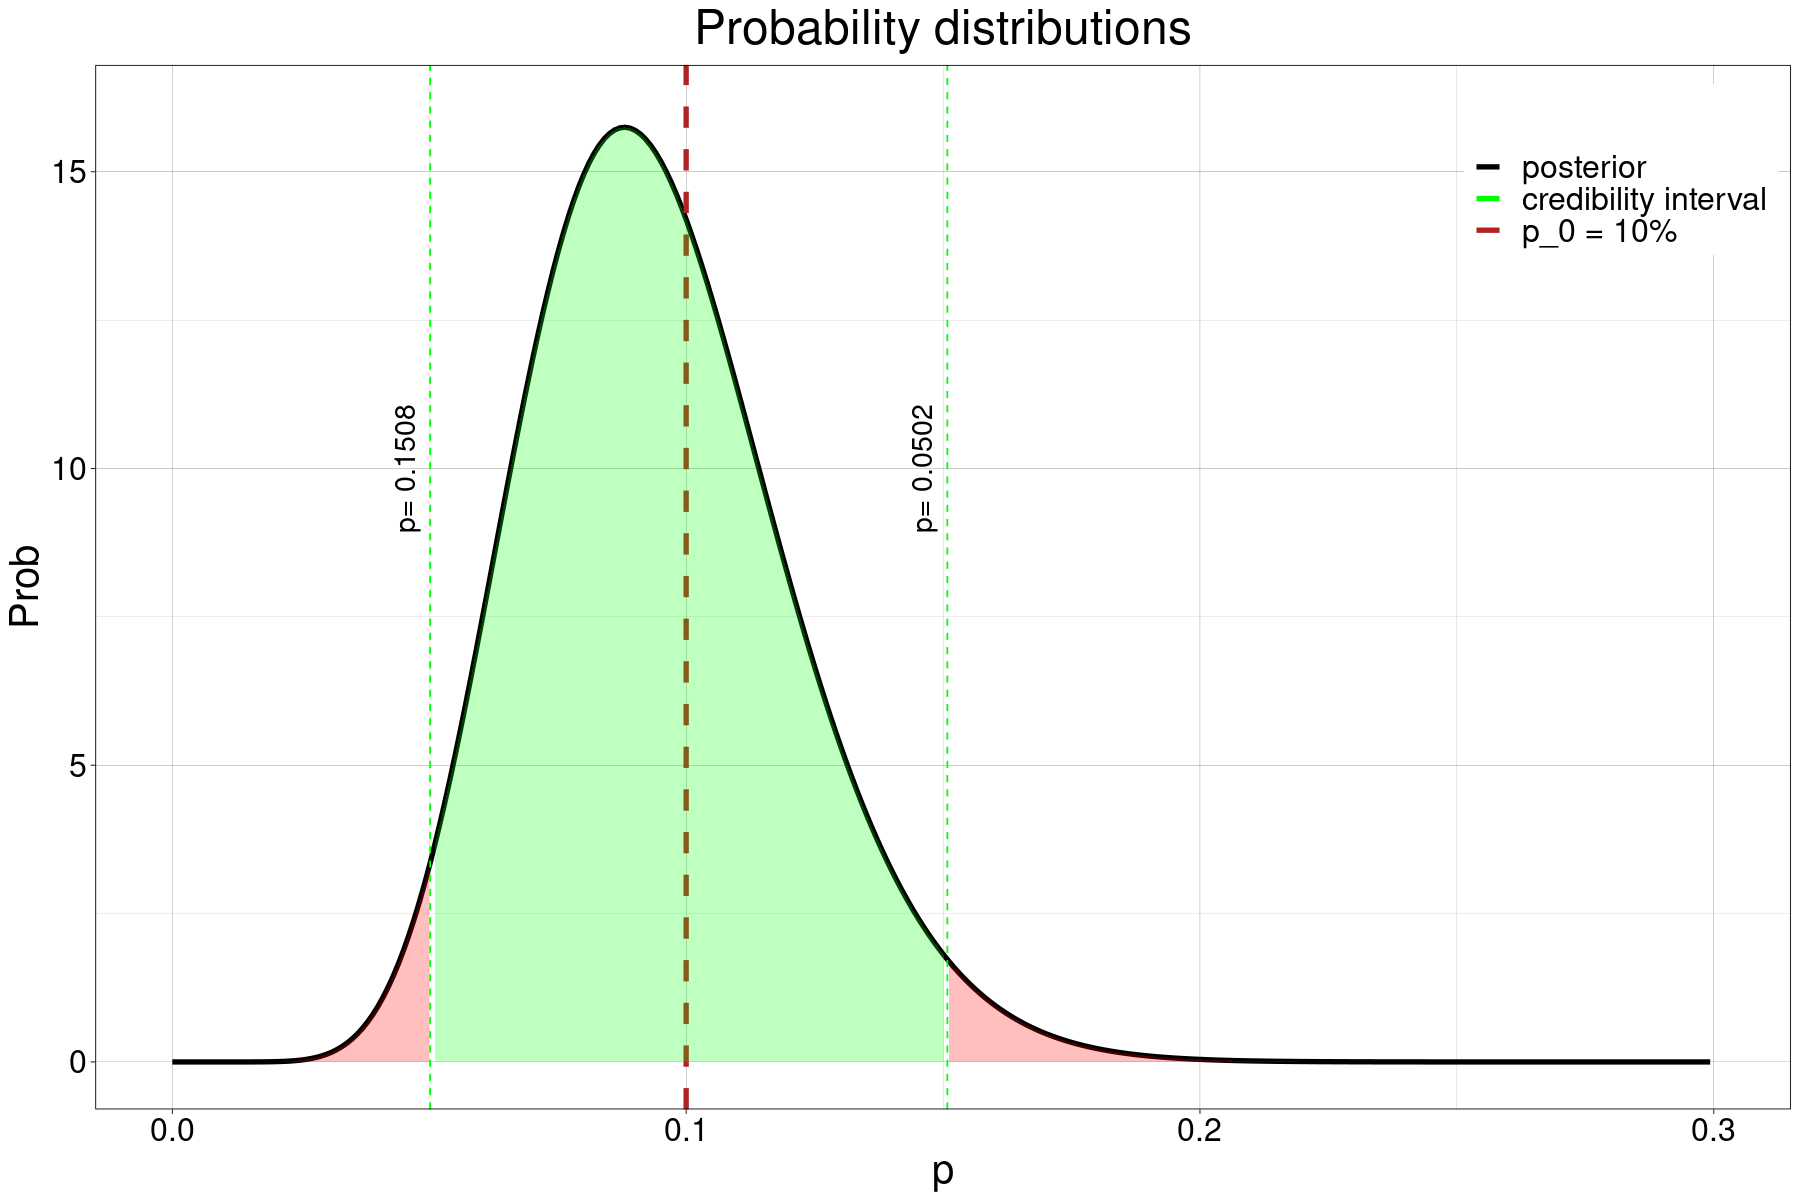

In [134]:
p_h0 <- 0.1
a <- 0.05

plot <- ggplot() +
        geom_line(aes(x=p, y=post, color="posterior"),lwd=1.5) + 
        geom_vline(xintercept = p_h0, linetype="dashed", color="firebrick", lwd=1.5) +
        geom_vline(xintercept = low, linetype="dashed", color="green") +
        geom_vline(xintercept = high, linetype="dashed", color="green") +
        geom_area(aes(x = ifelse(p>low & p< high , p, 0), y=post,), fill=adjustcolor("green",alpha.f=0.25))+
        geom_area(aes(x = ifelse(p<low , p, 0), y=post,), fill=adjustcolor("red",alpha.f=0.25))+
        geom_area(aes(x = ifelse(p>high , p, 0), y=post,), fill=adjustcolor("red",alpha.f=0.25))+
        theme_linedraw() +
        xlim(0,0.3)+
        ylim(0,16)+
       
        annotate("text", x=low-0.005, y=10, label= paste("p=",round(high,4)),angle=90, size=6) + 
        annotate("text", x=high-0.005, y=10, label= paste("p=",round(low,4)),angle=90, size=6) + 
      
        scale_color_manual(name = "", values = c("posterior" = "black","credibility interval"="green", "p_0 = 10%" = "firebrick" ))+
        labs(title=glue("Probability distributions"), x="p",y="Prob")+
        theme(text = element_text(size=24), plot.title = element_text( hjust = 0.5), legend.position=c(.9,.90))
plot


Hence, since $P_0$ falls in the acceptance region we can not reject the null hypothesis at level of significance .

### Frequentist HT

Warning message:
“Removed 86 rows containing missing values (position_stack).”
Warning message:
“Removed 1 rows containing missing values (geom_bar).”


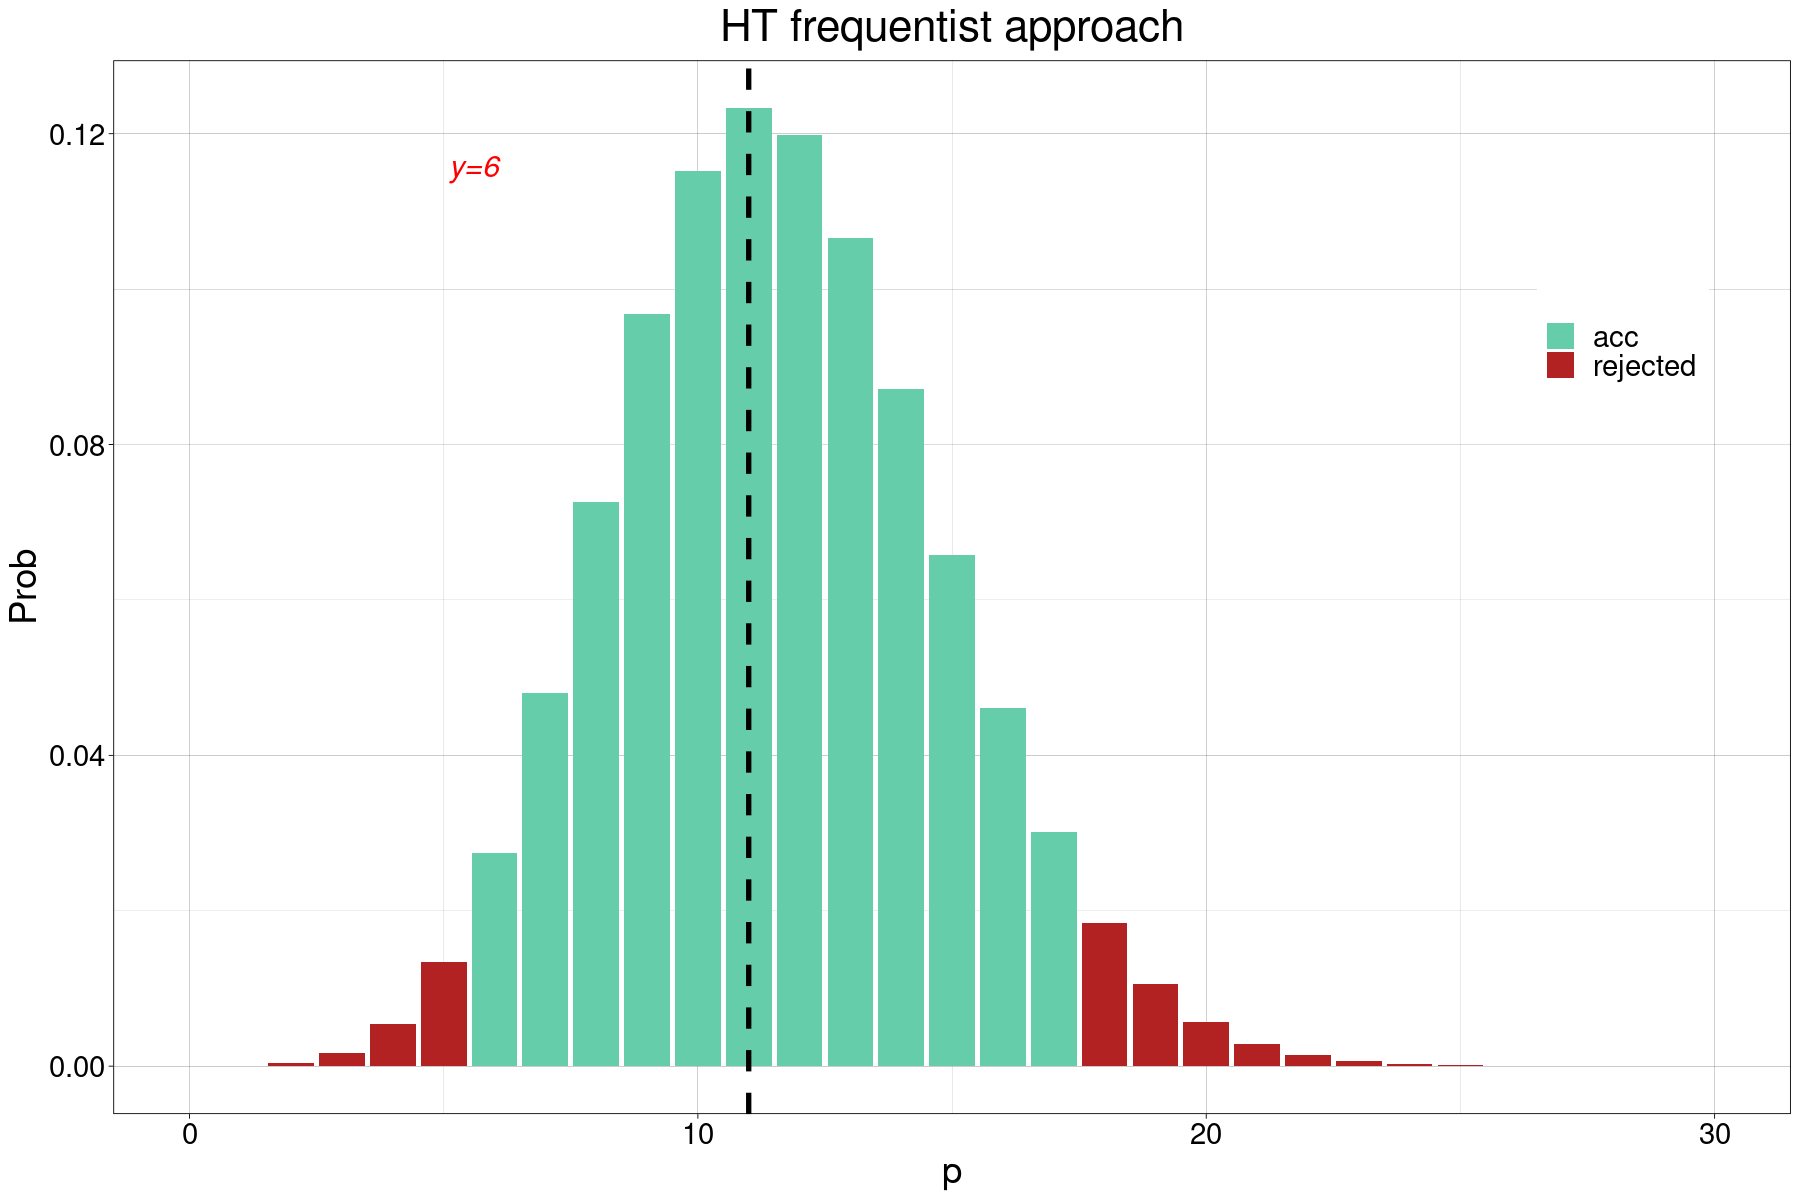

In [176]:
n <- 116
y <- 11
y_i <- 1:n

p_test <- pbinom(y_i, n, 0.1)


y_acc <- y_i[p_test > 0.025 & p_test<0.975]
y_rej_left  <- y_i[p_test < 0.025]
y_rej_right <- y_i[p_test > 0.975]

pp_test <- dbinom(y_i, n, p_h0)
col <- c(rep("rejected",length(y_rej_left)),rep("acc",length(y_acc)),rep("rejected",length(y_rej_right)) )

df <- data.frame(y_i, pp_test,col)

options(repr.plot.width=15, repr.plot.height=10)

barp <- ggplot(df, aes(x=y_i, y=pp_test,fill=col)) +
        geom_bar(stat="identity")+
        geom_vline(xintercept = y, linetype="dashed", color="black", lwd=1.5) +
        theme_linedraw() +
        xlim(0,30)+
        scale_fill_manual(name="",values = c(adjustcolor("aquamarine3",alpha.f=1),adjustcolor("firebrick",alpha.f=1)) )+
        labs(title=glue("HT frequentist approach"), x="p",y="Prob")+
        theme(text = element_text(size=22), plot.title = element_text( hjust = 0.5), 
                legend.position=c(.9,.75))+
        annotation_custom(grobTree(textGrob("y=6", x=0.2,  y=0.9, hjust=0,gp=gpar(col="red", fontsize=18, fontface="italic"))))
barp


New measurement

In [153]:
n <- 165 
y <- 9
p_freq2 <- y/n

alpha_prior1 <- 1
beta_prior1  <- 10
alpha_prior2 <- 12
beta_prior2  <- 115

alpha_post1 <- alpha_prior1 + y 
beta_post1  <- beta_prior1 + n - y
alpha_post2 <- alpha_prior2 + y
beta_post2  <- beta_prior2 + n - y

mu_post1  <- alpha_post1 / (alpha_post1 + beta_post1)
std_post1 <- sqrt((alpha_post1*beta_post1)/((alpha_post1+beta_post1)^2*(alpha_post1+beta_post1+1)))
mu_post2  <- alpha_post2 / (alpha_post2 + beta_post2)
std_post2 <- sqrt((alpha_post2*beta_post2)/((alpha_post2+beta_post2)^2*(alpha_post2+beta_post2+1)))


In [155]:
#results
cat("The frequentist estimator for p =",round(p_freq2,3),"\n")

The frequentist estimator for p = 0.055 
